# Predicting Star Ratings


In [4]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [5]:
star_ratings = [row['stars'] for row in data]

## 1 city model using city location

build a custom estimator that will make a prediction based solely on the city of a venue. 

This custom estimator will have a `.fit()` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `.predict()` method can look up the average rating for the city of each record it receives.

In [13]:
from sklearn import base
import numpy as np

class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        self.avg_stars = avg_stars
        return self
    
    def predict(self, X):
        return [self.avg_stars[row['city']] if row['city'] in avg_stars else np.mean(star_ratings) for row in X ]

In [14]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

## 2 latitude, longitude model

Assume city location is correlated to ratings. Buit a colum selecter to extract latitude, longitude data and apply knn

In [18]:
import pandas as pd
df = pd.DataFrame(data)

In [19]:
import pandas as pd
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        df= pd.DataFrame(X)
        return df[self.col_names].values.tolist()
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names

In [21]:
from sklearn.neighbors import KNeighborsRegressor
cst = ColumnSelectTransformer(['latitude', 'longitude'])
data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

In [22]:
from sklearn.pipeline import Pipeline
knn = KNeighborsRegressor()

pipe = Pipeline([
        # ColumnSelectTransformer
        # KNeighborsRegressor
        ('ColnumSelectTransformer',ColumnSelectTransformer(['latitude', 'longitude'])),('KNN',knn)
    ])

In [23]:
pipe.fit(data, star_ratings)
pipe.predict(test_data)

array([4. , 4.2, 4. , 3.8, 4.2])

In [159]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import model_selection

# xtrain,xtest,ytrain,ytest = train_test_split(data_transform,star_ratings,test_size = 0.3, shuffle = True,random_state=0)

#random shuffle the data because there
cv = model_selection.ShuffleSplit(n_splits = 20, test_size = 0.2, random_state=42)
knn = KNeighborsRegressor()
tune = [{'n_neighbors':list(range(5,100,4))}]

model = GridSearchCV(knn,param_grid= tune,cv=cv)
model.fit(data_transform,star_ratings)
# model.fit(xtrain,ytrain)
print(model.best_score_)
print(model.best_estimator_.n_neighbors)

0.019923405722102574
89


plot the data to see the trend, we know that data should be shuffled

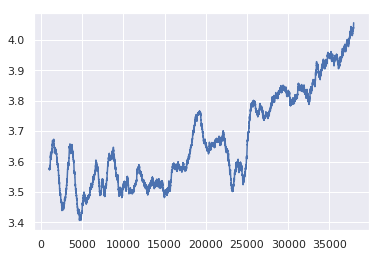

In [89]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean())

In [24]:
lat_long_est= Pipeline([
        # ColumnSelectTransformer
        # KNeighborsRegressor
        ('ColnumSelectTransformer',ColumnSelectTransformer(['latitude', 'longitude'])),('KNN',KNeighborsRegressor(n_neighbors=89))
    ]).fit(data,star_ratings)

# lat_long_est= KNeighborsRegressor(n_neighbors=89)

## 3 category model

In [206]:
import pandas as pd
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        df= pd.DataFrame(X)
        return df[self.col_names].values.tolist()
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        

In [27]:
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        emp = []
        for i in range(len(X)):
            dic = defaultdict(int)
            for item in X[i][0]:
                dic[item] +=1
            emp.append(dict(dic))

        return emp
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.

Built a pipeline `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, `Ridge Regression`

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfTransformer

pipe_cat = Pipeline([('Col', ColumnSelectTransformer(['categories'])),('encoder',DictEncoder()),\
                      ('Vectorizer',DictVectorizer(sparse=False)),('tfidf',TfidfTransformer()),('Ridge',Ridge(alpha = 6.3))])

## 4 attribute model

Extract data from dictionary within dictionay

In [38]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v*1))

    dic=[]
    for k,v in items:

        if isinstance(v, str):
            name = k+'_'+v
            dic.append((name,1))
        else:
            dic.append((k,v))        

    return dict(dic)

class flatten_dict(base.BaseEstimator, base.TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        output = []
        for i in range(len(X)):
            output.append(flatten(X[i][0]))
            #clean empty {}
#             out = list(filter(None,output))
        return output
    

In [39]:
cc = ColumnSelectTransformer(col_names=['attributes']).fit_transform(data[:10])

In [40]:
pipe_data_attr = Pipeline([('Col', ColumnSelectTransformer(['attributes'])),('flat',flatten_dict()),\
                      ('Vectorizer',DictVectorizer(sparse=False))])
data_attr = pipe_data_attr.fit_transform(data)
data_attr.shape

(37938, 93)

Built a linear Regression model and fit the residual using random forest to get better result

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
# cv = model_selection.ShuffleSplit(n_splits = 20, test_size = 0.2, random_state=42)
# predicted = cross_val_predict(lr,data_attr,star_ratings,cv=cv)

model_lr = lr().fit(data_attr,star_ratings)
predict = model_lr.predict(data_attr)
resid = predict-star_ratings

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import model_selection

cv = model_selection.ShuffleSplit(n_splits = 20, test_size = 0.2, random_state=42)

model_rf = RandomForestRegressor(random_state=42)
param_grid = [{'n_estimators': [60,70,80,90,100],
               'max_depth':[30,40],
               'min_samples_leaf': [10,15,20]}]
grid_search = GridSearchCV(model_rf, param_grid,n_jobs=-1,cv=cv)
grid_search.fit(resid.reshape(-1, 1),star_ratings)
print(grid_search.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [42]:
class Estimator(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,lr,rf):
        self.lr = lr
        self.rf = rf
    
    def fit(self, X, y):
        pred = self.lr.fit(X,y).predict(X)
        resid = y-pred
        self.rf.fit(X,resid.reshape(-1,1))
        return self
   
    def predict(self, X):        
        return self.rf.predict(X)+self.lr.predict(X)
        

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
rf =RandomForestRegressor(max_depth=30,
                          min_samples_leaf=10, 
                          min_samples_split=2,
                          n_estimators=100)
lr = LinearRegression()

In [46]:
attribute_est = Pipeline([('Col', ColumnSelectTransformer(['attributes'])),
                           ('flat',flatten_dict()),                           
                           ('Vectorizer',DictVectorizer(sparse=False)),
                           ('lr&rf',Estimator(lr,rf))]).fit(data,star_ratings)

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


## full_model

Using a stacking method of linear regression, treat the output of previous model as features for the final model

In [ ]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator=estimator):
        self.estimator=estimator
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
        
        # if we use self.fit(X,y), it will be a dead-loop
        (self.estimator).fit(X,y)
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        return np.array((self.estimator).predict(X)).reshape(-1,1)

In [89]:
city_trans = EstimatorTransformer(estimator=city_est)
lat_lon_trans = EstimatorTransformer(estimator=lat_long_est)
cat_trans = EstimatorTransformer(estimator=category_est)
attr_trans = EstimatorTransformer(estimator=attribute_est)

In [73]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([('city',cityTransformer(city_est)),
                      ('lat_long',latlongTransformer(lat_long_est)),
                      ('category',catTransformer(category_est)),
                      ('attribute',attrTransformer(attribute_est))
        # FeatureUnions use the same syntax as Pipelines
    ])

In [388]:
full_est = LinearRegression().fit(unioun_output,star_ratings)

In [94]:
full_est = Pipeline([('union',union),('lr',LinearRegression())]).fit(data,star_ratings)

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
